## Import ##

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from model_profiler import model_profiler
import pathlib
from pathlib import Path
import cv2 as cv
import json
import pandas as pd
import nvidia_smi
from numba import cuda

batch_size = 20
epoch_size = 3000
test_len = 8

In [2]:
def flatten(l):
    return [item for sublist in l for item in sublist]


def get_txt_data(path: Path) -> np.ndarray:
    with path.open("r", encoding="utf-8") as f:
        result: list = json.loads(f.readline())
        return np.array(flatten(result))


# p = pathlib.Path('../../openCV_python/data/out/resized_frames/resized')
# txt_files = list(p.glob('*.txt'))
# img_files = [item.parent.resolve() / item.stem for item in txt_files]
# txt_files[0].stem
# image = txt_files[0].parent.resolve() / txt_files[0].stem

# img_count = len(txt_files)
# img_shape = cv.imread(str(image)).shape

# txt_shape = get_txt_data(txt_files[0]).shape

# input_shape = (img_count, *img_shape)
# output_shape = (img_count, *txt_shape)
input_data: np.ndarray = np.load('data/train_input.npy')
output_data: np.ndarray = np.load('data/train_output.npy')
input_shape = input_data.shape[1:]
output_shape = output_data.shape[1:]
# data = []

# for i in range(len(img_files)):
#     input_data[i] = cv.imread(str(img_files[i]))
#     output_data[i] = get_txt_data(txt_files[i])

print('input shape')
print(input_shape)
print()
print('output shape')
print(output_shape)


def load_data():
    l = len(input_data)
    last = l - 1
    first = int(l-l/test_len)
    train_images = input_data[0:first]
    train_labels = output_data[0:first]

    test_images = input_data[first:last]
    test_labels = output_data[first:last]
    print('Train shape: {}'.format(train_images.shape))
    print('Test shape: {}'.format(test_images.shape))

    return (train_images, train_labels), (test_images, test_labels)


input shape
(29, 20)

output shape
(8,)


In [3]:
(train_images, train_labels), (test_images, test_labels) = load_data()
input_shape = train_images.shape[1:3]


Train shape: (7409, 29, 20)
Test shape: (1058, 29, 20)


In [4]:
activation_fun = 'gelu'
print(np.prod(input_shape))

normalization = tf.keras.layers.Normalization(axis=None)
normalization.adapt([0,255.0])

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(input_shape))
model.add(normalization)
model.add(tf.keras.layers.Conv1D(32, 3, activation=activation_fun))
model.add(tf.keras.layers.Conv1D(32, 3, activation=activation_fun))
model.add(tf.keras.layers.MaxPooling1D(2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024 * 120, activation_fun))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1024, activation_fun))
model.add(tf.keras.layers.Dense(8))

model.summary()


580
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 29, 20)           3         
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 27, 32)            1952      
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 122880)         

In [5]:
# profile = model_profiler(model, batch_size)

# print(profile)


In [6]:
model.compile(optimizer='adam',
              loss="mae",)

history = model.fit(
    train_images, train_labels,
    epochs=epoch_size,
    batch_size=batch_size,
    validation_data=(test_images, test_labels)
)


Epoch 1/3000
371/371 [==============================] - 13s 25ms/step - loss: 91.3734 - val_loss: 64.7888
Epoch 2/3000
371/371 [==============================] - 9s 24ms/step - loss: 56.0810 - val_loss: 49.9538
Epoch 3/3000
371/371 [==============================] - 9s 24ms/step - loss: 45.9030 - val_loss: 40.5857
Epoch 4/3000
371/371 [==============================] - 9s 24ms/step - loss: 39.5057 - val_loss: 41.5550
Epoch 5/3000
371/371 [==============================] - 9s 24ms/step - loss: 33.8827 - val_loss: 33.3528
Epoch 6/3000
371/371 [==============================] - 9s 24ms/step - loss: 31.1522 - val_loss: 31.3651
Epoch 7/3000
371/371 [==============================] - 9s 24ms/step - loss: 27.6481 - val_loss: 28.6009
Epoch 8/3000
371/371 [==============================] - 9s 24ms/step - loss: 25.5985 - val_loss: 28.3595
Epoch 9/3000
371/371 [==============================] - 9s 24ms/step - loss: 24.4913 - val_loss: 24.3203
Epoch 10/3000
371/371 [==============================]

KeyboardInterrupt: 

In [ ]:
history: dict = history.history
loss = history['loss']
val_loss = history['val_loss']
l = int(len(loss) / 10)
history['loss'] = loss[l:]
history['val_loss'] = val_loss[l:]


{'loss': [4.769547462463379, 4.955953121185303, 5.111180782318115, 4.978438854217529, 4.888323783874512, 4.923442840576172, 4.947481632232666, 4.867370128631592, 4.952585697174072, 4.9680681228637695, 5.012650012969971, 5.0048508644104, 4.743444442749023, 4.9617085456848145, 4.939483642578125, 4.925159931182861, 5.026388645172119, 4.916500568389893, 4.90622091293335, 4.947851181030273, 4.874520778656006, 4.949422836303711, 4.920588970184326, 4.872878074645996, 4.871496677398682, 4.960616111755371, 4.796778678894043, 4.91497802734375, 4.813197612762451, 4.789255142211914, 4.703329086303711, 4.832049369812012, 4.843849182128906, 4.76781702041626, 4.775174140930176, 4.892934799194336, 4.724823951721191, 4.825403690338135, 4.751783847808838, 4.879762172698975, 4.847009658813477, 4.701156139373779, 4.685384750366211, 4.663848876953125, 4.69913911819458, 4.768103122711182, 4.766345500946045, 4.6825480461120605, 4.8012003898620605, 4.878106594085693, 4.902676105499268, 4.662917137145996, 4.57

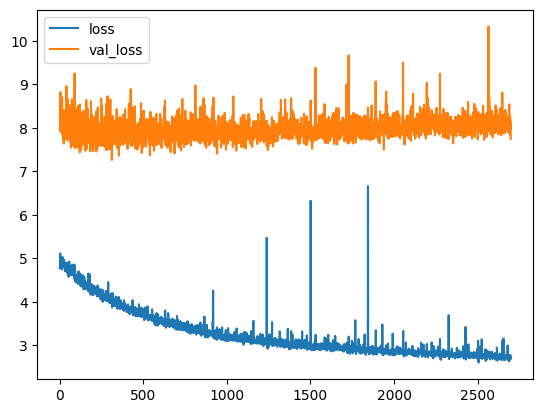

In [ ]:

print(history)
history_df = pd.DataFrame(history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)


In [ ]:
# print(test_acc)

# cuda.select_device(0)
# cuda.close()


In [ ]:
model.save('out')

INFO:tensorflow:Assets written to: out\assets


INFO:tensorflow:Assets written to: out\assets
